In [1]:
import pandas as pd
import random
data_input = pd.read_csv(r"E:\wumeiyun(last-first)\MachineLearningLast1_change2.csv")
# print("读入的非空数据:\n",data_input)

# 非数值转数值
X_gender = data_input.iloc[:, data_input.columns == "gender"]
X_gender_encode = pd.get_dummies(X_gender, drop_first=True)
X_CI = data_input.iloc[:, data_input.columns == "CI"]
X_CI_encode = pd.get_dummies(X_CI, drop_first=True)

X_new = pd.concat([
    
      data_input.iloc[:, data_input.columns == "times"]  # 1
    , data_input.iloc[:, data_input.columns == "HAtime"]  # 2
    , X_gender_encode  # 3
    , data_input.iloc[:, data_input.columns == "age_implantation"]  # 4
    , X_CI_encode.iloc[:, X_CI_encode.columns == "CI_L"]  # 5
    , X_CI_encode.iloc[:, X_CI_encode.columns == "CI_R"]  # 6
    , data_input.iloc[:, data_input.columns == "CIU"]  # 7
    , data_input.iloc[:, data_input.columns == "NonCIU"]  # 8
      
    
], axis=1)
Y_new = data_input.loc[:, "score"]

data_value = pd.concat([Y_new, X_new], axis=1)
print(data_value.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47 entries, 0 to 46
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   score             47 non-null     int64  
 1   times             47 non-null     float64
 2   HAtime            47 non-null     int64  
 3   gender_girl       47 non-null     uint8  
 4   age_implantation  47 non-null     int64  
 5   CI_L              47 non-null     uint8  
 6   CI_R              47 non-null     uint8  
 7   CIU               47 non-null     int64  
 8   NonCIU            47 non-null     int64  
dtypes: float64(1), int64(5), uint8(3)
memory usage: 2.4 KB
None


In [2]:
# --------------------------------------------------------

import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import RFE
from sklearn.svm import SVC

from sklearn import svm
from sklearn.metrics import roc_curve, auc , accuracy_score ,recall_score,precision_score
from sklearn.model_selection import StratifiedKFold, LeaveOneOut
# --------------------------------------------------------


X = data_value.iloc[:, data_value.columns != "score"]
Y = data_value.iloc[:, data_value.columns == "score"]

Y = np.array(Y)
columns = X.columns

X = StandardScaler().fit_transform(X)#标准化

2


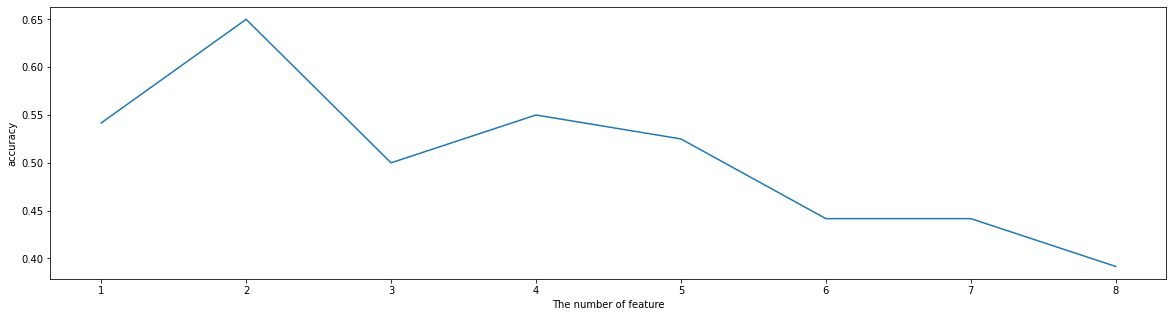

In [3]:
#24 2
from sklearn.model_selection import train_test_split
Xtrain,Xtest,Ytrain,Ytest=train_test_split(X,Y,test_size=0.1,shuffle=True,random_state=24
                                           #max_random_state
                                          )  #10%测试集     #7(change)   #20(behavior+change)

import warnings
warnings.filterwarnings("ignore")

#特征选择
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import RFE
from sklearn.svm import SVC
%matplotlib inline
import matplotlib.pyplot as plt

svc = SVC(kernel="linear")
score=[]
compare_index=0
compare_score=0
for i in range(1,9,1):
    X_wrapper=RFE(svc,n_features_to_select=i,step=1).fit_transform(Xtrain,Ytrain)
    once=cross_val_score(svc,X_wrapper,Ytrain,scoring='accuracy',cv=10).mean()
    score.append(once)
    if once>compare_score:
        compare_score=once
        compare_index=i
    
print(compare_index)      
plt.figure(figsize=[20,5])
plt.plot(range(1,9,1),score)
plt.xticks(range(1,9,1))
plt.xlabel("The number of feature")
plt.ylabel("accuracy")
plt.show()


In [4]:
rfe=RFE(svc,n_features_to_select=compare_index,step=1)
rfe_wrapper=rfe.fit(Xtrain,Ytrain)
X_train_wrapper=rfe_wrapper.transform(Xtrain)
X_test_wrapper=rfe_wrapper.transform(Xtest)
print(X_test_wrapper.shape)
X_wrapper=rfe_wrapper.transform(X)
print(X_wrapper.shape)
cross_val_score(svc,X_train_wrapper,Ytrain,scoring='accuracy',cv=10).mean()

(5, 2)
(47, 2)


0.65

In [5]:
pd.set_option('max_row',300)
pd.DataFrame(rfe.support_,index=columns,columns=['Rank'])#输出表格

,Rank
times,False
HAtime,True
gender_girl,False
age_implantation,True
CI_L,False
CI_R,False
CIU,False
NonCIU,False


In [6]:
clf=SVC(kernel="linear").fit(X_train_wrapper,Ytrain)#18个特征，训练集拟合你的分类器

score=clf.score(X_test_wrapper,Ytest)#在测试集上测试
print(score)

0.8


In [7]:
import warnings
warnings.filterwarnings("ignore")

area_list = []
precision_list = []
accuracy_list=[]
recall_list=[]

import numpy as np
import matplotlib.pyplot as plt
from scipy import interp  # 插值
from sklearn import svm
from sklearn.metrics import roc_curve, auc , accuracy_score ,recall_score,precision_score
from sklearn.model_selection import StratifiedKFold, LeaveOneOut

for num in range(10000):
    #print(num)
    cv = StratifiedKFold(n_splits=10,shuffle=True,random_state=num)
    classifier = svm.SVC(kernel='linear', probability=True)
    area = 0  # 面积AUC
    precision = 0
    accuracy=0#用混淆矩阵算出的准确率
    recall=0#sensitivity,tpr
    for train, test in cv.split(X_wrapper, Y):
        cla = classifier.fit(X_wrapper[train], Y[train])
        #print(train)
        #print(test)

        # pre = cla.score(X[test], Y[test])
        # precision += pre

        probas_ = cla.predict_proba(X_wrapper[test])
        fpr, tpr, thresholds = roc_curve(Y[test], probas_[:, 1], pos_label=1)
        roc_auc = auc(fpr, tpr)
        area += roc_auc

        prec = precision_score(Y[test], cla.predict(X_wrapper[test]))
        precision += prec

        acc=accuracy_score(Y[test],cla.predict(X_wrapper[test]))
        accuracy+=acc

        rec=recall_score(Y[test],cla.predict(X_wrapper[test]))
        recall+=rec

    area_list.append(area / 10)
    precision_list.append(precision / 10)
    accuracy_list.append(accuracy/10)
    recall_list.append(recall / 10)

    #print("---------------------------------------------------------")


from collections import Counter

# 使用collections.Counter()函数
# 直接collections.Counter(list)就可以得到list中每个元素的个数
# 返回类型是collections.Counter，可以将其手动转换为dict
def get_count_by_counter(l):
    count = Counter(l)  # 类型： <class 'collections.Counter'>
    count_dict = dict(count)  # 类型： <type 'dict'>
    return count_dict

average_AUC = np.mean(area_list)
average_PRECISION=np.mean(precision_list)
average_ACCURACY=np.mean(accuracy_list)
average_RECALL=np.mean(recall_list)

print("ok")
# print("AUC",sorted(get_count_by_counter(area_list).items(), key=lambda item:item[1], reverse=True))
# print("PRECISION",sorted(get_count_by_counter(precision_list).items(), key=lambda item:item[1], reverse=True))
# print("ACCURACY",sorted(get_count_by_counter(accuracy_list).items(), key=lambda item:item[1], reverse=True))
# print("RECALL(SENSITIVITY)",sorted(get_count_by_counter(recall_list).items(), key=lambda item:item[1], reverse=True))

ok


In [8]:
print("AUC:",average_AUC)
print("PRECISION",average_PRECISION)
print("ACCURACY",average_ACCURACY)
print("RECALL",average_RECALL)

AUC: 0.5989486111111111
PRECISION 0.6918823333333333
ACCURACY 0.6652488333333334
RECALL 0.5865833333333332


In [9]:
pd.DataFrame(accuracy_list).to_csv("E:\\wumeiyun(last-first)\\method3\\clinical.csv")